# LightGBM tuning
Goal: tune a LightGBM model with cleaned samples.
***

## Table of Contents 

1. [Intuition Behind Tuning Approach](#1.-Intuition-Behind-Tuning-Approach)
2. [Intuition Behind Evaluation Metrics](#2.-Intuition-Behind-Tuning-Metrics)
3. [Load Data](#3.-Load-Data)
4. [Define Functions](#4.-Define-Functions)
5. [Building a Baseline Model](#5.-Building-a-Baseline-Model)
6. [Equalize Class Imbalance](#6.-Equalize-Class-Imbalance)

## 1. Intuition Behind Tuning Approach
1. Tune parameters for the leaf-wise (best-first) tree.
2. Tune for faster speed.
3. Tune for more accurate predictions.
4. Control overfitting.

## 2. Intuition Behind Evaluation Metrics

Click this [link](https://github.com/ayn28/churn-prediction-modeling/blob/master/model-tuning/XGBoost-tuning.ipynb) or copy and paste the link below into your browser to read about the intuition behind choosing the evaluation metrics. 

https://github.com/ayn28/churn-prediction-modeling/blob/master/model-tuning/XGBoost-tuning.ipynb

## 3. Load Data

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Import cleaned datasets
df = pd.read_csv('data/cleaned_data/og_cleaned_samples.csv', index_col='customerID')
df_cat_encoded = pd.read_csv('data/cleaned_data/num_cleaned_samples.csv', index_col='customerID')

# Create features and target arrays
X = df_cat_encoded.drop(['Churn_Yes', 'gender_Male'], axis=1).values
y = df_cat_encoded.Churn_Yes.values

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

To create our features array, we drop the Churn feature since that is our target variable and we are trying to predict its labels. From our EDA, we determined that a customer's gender likely has no effect on their propensity to churn since it wasn't strongly correlated with other features and had no notable differences in churn rates between genders.
***

### 4. Define Functions

In [89]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import collections
import seaborn as sns
%matplotlib inline
sns.set()

def fit_model(clf_name):
    """Fit a classifier to the training data."""
    clf_name.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc'],    # Will document logloss (by default) and AUC
        early_stopping_rounds=10,
        verbose=False
    )

# Define function to calculate evaluation metrics.
def metrics(clf_name, results_list):
    """Calculate and output evaluation metrics."""
        # Print best iteration round number
    print('Best iteration at {} rounds.'.format(clf_name.best_iteration_))
        # Calculate AUC, AUCPR, and Logloss
    auc_mtr = [i for i in clf_name.best_score_.values()][0]['auc']
    logloss_mtr = [i for i in clf.best_score_.values()][0]['binary_logloss']
        # Calculate AUCPR
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    aucpr_mtr = average_precision_score(y_test, preds)
    print('AUC:       {0:.3f}'.format(auc_mtr))
    print('AUCPR:     {0:.3f}'.format(aucpr_mtr))
    print('Logloss:   {0:.3f}'.format(logloss_mtr))
        # Calculate precision, recall, and f1-score
    binary_preds = clf_name.predict(X_test)
    print('Precision: {0:.3f}'.format(precision_score(y_test, binary_preds)))
    print('Recall:    {0:.3f}'.format(recall_score(y_test, binary_preds)))
    print('f1-score:  {0:.3f}'.format(f1_score(y_test, binary_preds)))
    
    # Append metrics in a list for plotting
    results_list.append([
        round(auc_mtr, 3),
        round(aucpr_mtr, 3),
        round(logloss_mtr, 3),
        round(precision_score(y_test, binary_preds), 3),
        round(recall_score(y_test, binary_preds), 3),
        round(f1_score(y_test, binary_preds), 3)
    ])

# Define function to plot ROC curve.     
def plot_roc(clf_name):
    """Plot the ROC curve for a given classifier."""
    # Calculate the fpr and tpr for all thresholds of the classification
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(7, 7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Define function to plot PR curve.
def plot_pr(clf_name):
    """Plot the precision-recall curve for a given classifier."""
    # Calculate the precision and recall for all thresholds of the classification
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    average_precision = average_precision_score(y_test, preds)

    # Plot PR curve
    plt.figure(figsize=(7, 7))
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Define function to plot ROC and PR curve.
def plot_roc_pr(clf_name):
    """Plot the ROC and PR-curve for a given classifier."""
    plt.figure(figsize=(14, 7))
    # Plot ROC
    plt.subplot(121)
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # Plot PR curve
    plt.subplot(122)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    average_precision = average_precision_score(y_test, preds)
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

### 5. Building a Baseline Model
In order to get an idea of the range of precision and recall we would like our model to surpass, we are going to build a baseline model and save its score for later. This score is what we can achieve with no tuning. 

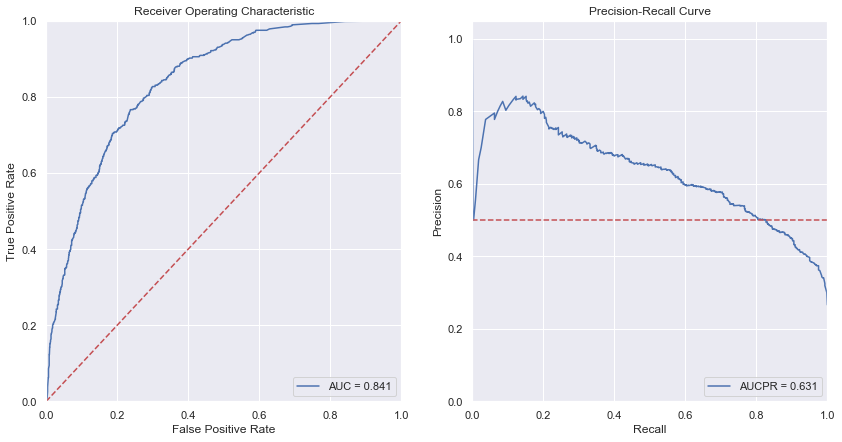

Best iteration at 14 rounds.
AUC:       0.841
AUCPR:     0.631
Logloss:   0.435
Precision: 0.684
Recall:    0.390
f1-score:  0.497


In [69]:
import lightgbm as lgb

# Define parameters
params = {
    'verbosity': 0,
    'seed': 42,
    'objective': 'binary'
}

# Instantiate a classifier (using all default parameters)
clf = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf)

# Plot metrics
plot_roc_pr(clf)

# Output evaluation metrics
results_list = []
metrics(clf, results_list)

### 6. Equalize Class Imbalance
Most notably in this step, we apply more weight to the positive "churn" class. We apply the ratio of negative-to-positive classes to the positive class.

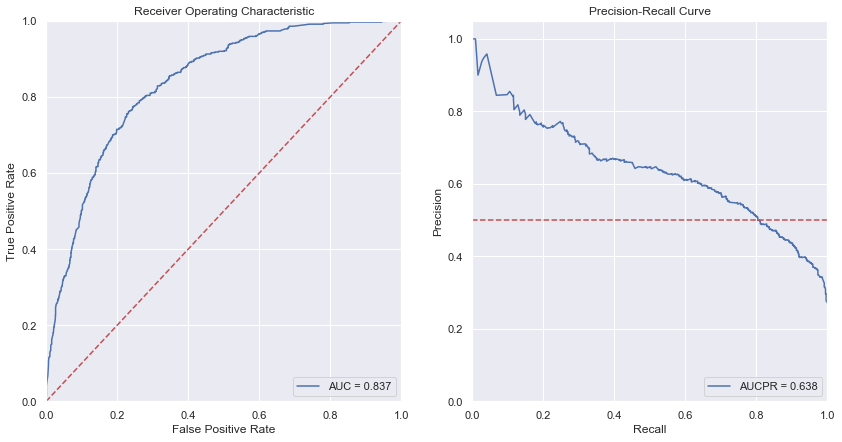

Best iteration at 13 rounds.
AUC:       0.837
AUCPR:     0.638
Logloss:   0.435
Precision: 0.558
Recall:    0.717
f1-score:  0.628


In [70]:
# Load data into Dataset objects (optimized for LightGBM)
# (very memory-efficient b/c it only saves discrete bins)
dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test)

# Balance the positive and negative weights and assign it to the scale_pos_weight parameter
train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)

# Set hyperparameters
params = {
    'verbosity': 0,
    'seed': 42,
    'objective': 'binary',
    'scale_pos_weight': ratio
}

# Instantiate classifier
clf1 = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf1)

# Plot metrics
plot_roc_pr(clf1)

# Output evaluation metrics 
results_list1 = []
metrics(clf1, results_list1)

Let's compare the baseline model to the equalized model and further analyze the changes.

In [85]:
print('Baseline model:')
metrics(clf, results_list)

print('\nEqualized model:')
metrics(clf1, results_list1)

Baseline model:
Best iteration at 14 rounds.
AUC:       0.841
AUCPR:     0.631
Logloss:   0.435
Precision: 0.684
Recall:    0.390
f1-score:  0.497

Equalized model:
Best iteration at 13 rounds.
AUC:       0.837
AUCPR:     0.638
Logloss:   0.435
Precision: 0.558
Recall:    0.717
f1-score:  0.628


In [81]:
results_list

[[0.841, 0.631, 0.435, 0.684, 0.39, 0.497],
 [0.841, 0.631, 0.435, 0.684, 0.39, 0.497],
 [0.841, 0.631, 0.435, 0.684, 0.39, 0.497],
 [0.841, 0.631, 0.435, 0.684, 0.39, 0.497],
 [0.841, 0.631, 0.435, 0.684, 0.39, 0.497]]

In [86]:
results_list1

[[0.837, 0.638, 0.435, 0.558, 0.717, 0.628],
 [0.837, 0.638, 0.435, 0.558, 0.717, 0.628],
 [0.837, 0.638, 0.435, 0.558, 0.717, 0.628],
 [0.837, 0.638, 0.435, 0.558, 0.717, 0.628],
 [0.837, 0.638, 0.435, 0.558, 0.717, 0.628],
 [0.837, 0.638, 0.435, 0.558, 0.717, 0.628]]

In [92]:
import collections

# Define function to calculate evaluation metrics.
def metrics(clf_name, results_set):
    """Calculate and output evaluation metrics."""
        # Print best iteration round number
    print('Best iteration at {} rounds.'.format(clf_name.best_iteration_))
        # Calculate AUC, AUCPR, and Logloss
    auc_mtr = [i for i in clf_name.best_score_.values()][0]['auc']
    logloss_mtr = [i for i in clf.best_score_.values()][0]['binary_logloss']
        # Calculate AUCPR
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    aucpr_mtr = average_precision_score(y_test, preds)
    print('AUC:       {0:.3f}'.format(auc_mtr))
    print('AUCPR:     {0:.3f}'.format(aucpr_mtr))
    print('Logloss:   {0:.3f}'.format(logloss_mtr))
        # Calculate precision, recall, and f1-score
    binary_preds = clf_name.predict(X_test)
    print('Precision: {0:.3f}'.format(precision_score(y_test, binary_preds)))
    print('Recall:    {0:.3f}'.format(recall_score(y_test, binary_preds)))
    print('f1-score:  {0:.3f}'.format(f1_score(y_test, binary_preds)))
    
    
    # Append metrics in a list for plotting
    results_set.append([
        round(auc_mtr, 3),
        round(aucpr_mtr, 3),
        round(logloss_mtr, 3),
        round(precision_score(y_test, binary_preds), 3),
        round(recall_score(y_test, binary_preds), 3),
        round(f1_score(y_test, binary_preds), 3)
    ])

## OrderedDict implementation
see if it stores duplicates

In [94]:
# Define function to calculate evaluation metrics.
def metrics(clf_name, ordered_dict):
    """Calculate and output evaluation metrics."""
    # Print best iteration round number
    print('Best iteration at {} rounds.'.format(clf_name.best_iteration_))
    # Calculate AUC, AUCPR, and Logloss
    auc_mtr = [i for i in clf_name.best_score_.values()][0]['auc']
    logloss_mtr = [i for i in clf.best_score_.values()][0]['binary_logloss']
    # Calculate AUCPR
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    aucpr_mtr = average_precision_score(y_test, preds)
    print('AUC:       {0:.3f}'.format(auc_mtr))
    print('AUCPR:     {0:.3f}'.format(aucpr_mtr))
    print('Logloss:   {0:.3f}'.format(logloss_mtr))
    # Calculate precision, recall, and f1-score
    binary_preds = clf_name.predict(X_test)
    print('Precision: {0:.3f}'.format(precision_score(y_test, binary_preds)))
    print('Recall:    {0:.3f}'.format(recall_score(y_test, binary_preds)))
    print('f1-score:  {0:.3f}'.format(f1_score(y_test, binary_preds)))
    
    # Append metrics to an ordered dictionary (for plotting)
    ordered_dict['AUC'] = round(auc_mtr, 3)
    ordered_dict['AUCPR'] = round(aucpr_mtr, 3)
    ordered_dict['Logloss'] = round(logloss_mtr, 3)
    ordered_dict['Precision'] = round(precision_score(y_test, binary_preds), 3)
    ordered_dict['Recall'] = round(recall_score(y_test, binary_preds), 3)
    ordered_dict['F1_score'] = round(f1_score(y_test, binary_preds), 3)

In [96]:
from collections import OrderedDict

# Instantiate classifier
clf1 = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf1)

# Output evaluation metrics 
results_dict1 = OrderedDict()
metrics(clf1, results_dict1)

Best iteration at 13 rounds.
AUC:       0.837
AUCPR:     0.638
Logloss:   0.435
Precision: 0.558
Recall:    0.717
f1-score:  0.628


In [97]:
results_dict1

OrderedDict([('AUC', 0.837),
             ('AUCPR', 0.638),
             ('Logloss', 0.435),
             ('Precision', 0.558),
             ('Recall', 0.717),
             ('F1_score', 0.628)])

In [98]:
metrics(clf1, results_dict1)

Best iteration at 13 rounds.
AUC:       0.837
AUCPR:     0.638
Logloss:   0.435
Precision: 0.558
Recall:    0.717
f1-score:  0.628


In [101]:
results_dict1

OrderedDict([('AUC', 0.837),
             ('AUCPR', 0.638),
             ('Logloss', 0.435),
             ('Precision', 0.558),
             ('Recall', 0.717),
             ('F1_score', 0.628)])

In [15]:
df = pd.DataFrame(
    np.array([results_set, results_set1])
)